<a href="https://colab.research.google.com/github/ldm2060/LearningNote/blob/main/DL%202023.6/week4/%E4%BD%9C%E4%B8%9A/hw04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Strong: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer.
  - Boss: Implement [Self-Attention Pooling](https://arxiv.org/pdf/2008.01077v1.pdf) & [Additive Margin Softmax](https://arxiv.org/pdf/1801.05599.pdf) to further boost the performance.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/ac77388c90204a4c8daebeddd40ff916)
  - Slide: [link](https://docs.google.com/presentation/d/1HLAj7UUIjZOycDe7DaVLSwJfXVd3bXPOyzSb6Zk3hYU/edit?usp=sharing)
  - Data: [link](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

# Download dataset
- Data is [here](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

In [ ]:
#!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partaa
#!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partab
#!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partac
#!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partad

#!cat Dataset.tar.gz.part* > Dataset.tar.gz

# unzip the file
#!tar zxvf Dataset.tar.gz

## Fix Random Seed

In [ ]:
!pip install Conformer
from conformer import ConformerBlock
import numpy as np
import torch
import random

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(87)

# Data

## Dataset
- Original dataset is [Voxceleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb2.
- We randomly select 600 speakers from Voxceleb2.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training.
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary.
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

In [ ]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


class myDataset(Dataset):
	def __init__(self, data_dir, segment_len=128):
		self.data_dir = data_dir
		self.segment_len = segment_len

		# Load the mapping from speaker neme to their corresponding id.
		mapping_path = Path(data_dir) / "mapping.json"
		mapping = json.load(mapping_path.open())
		self.speaker2id = mapping["speaker2id"]

		# Load metadata of training data.
		metadata_path = Path(data_dir) / "metadata.json"
		metadata = json.load(open(metadata_path))["speakers"]

		# Get the total number of speaker.
		self.speaker_num = len(metadata.keys())
		self.data = []
		for speaker in metadata.keys():
			for utterances in metadata[speaker]:
				self.data.append([utterances["feature_path"], self.speaker2id[speaker]])

	def __len__(self):
			return len(self.data)

	def __getitem__(self, index):
		feat_path, speaker = self.data[index]
		# Load preprocessed mel-spectrogram.
		mel = torch.load(os.path.join(self.data_dir, feat_path))

		# Segmemt mel-spectrogram into "segment_len" frames.
		if len(mel) > self.segment_len:
			# Randomly get the starting point of the segment.
			start = random.randint(0, len(mel) - self.segment_len)
			# Get a segment with "segment_len" frames.
			mel = torch.FloatTensor(mel[start:start+self.segment_len])
		else:
			mel = torch.FloatTensor(mel)
		# Turn the speaker id into long for computing loss later.
		speaker = torch.FloatTensor([speaker]).long()
		return mel, speaker

	def get_speaker_number(self):
		return self.speaker_num

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
	# Process features within a batch.
	"""Collate a batch of data."""
	mel, speaker = zip(*batch)
	# Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
	mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
	# mel: (batch size, length, 40)
	return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
	"""Generate dataloader"""
	dataset = myDataset(data_dir)
	speaker_num = dataset.get_speaker_number()
	# Split dataset into training dataset and validation dataset
	trainlen = int(0.9 * len(dataset))
	lengths = [trainlen, len(dataset) - trainlen]
	trainset, validset = random_split(dataset, lengths)

	train_loader = DataLoader(
		trainset,
		batch_size=batch_size,
		shuffle=True,
		drop_last=True,
		num_workers=n_workers,
		pin_memory=True,
		collate_fn=collate_batch,
	)
	valid_loader = DataLoader(
		validset,
		batch_size=batch_size,
		num_workers=n_workers,
		drop_last=True,
		pin_memory=True,
		collate_fn=collate_batch,
	)

	return train_loader, valid_loader, speaker_num

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttentionPooling(nn.Module):
	def __init__(self, input_dim):
		super(SelfAttentionPooling, self).__init__()
		self.sap_linaer = nn.Linear(input_dim, input_dim)
		self.attention = nn.Parameter(torch.FloatTensor(input_dim,1))
		torch.nn.init.normal_(self.attention, std=.02)

	def forward(self, x):
		# x = x.permute(0, 2, 1)
		h = torch.tanh(self.sap_linaer(x))
		w = torch.matmul(h, self.attention).squeeze(dim=2)
		w = F.softmax(w, dim=1).view(x.size(0), x.size(1), 1)
		x = torch.sum(x * w, dim=1)
		return x


class Classifier(nn.Module):
	def __init__(self, d_model=256, n_spks=600, dropout=0.1):
		super().__init__()
		# Project the dimension of features from that of input into d_model.
		self.prenet = nn.Linear(40, d_model)
		# TODO:
		#   Change Transformer to Conformer.
		#   https://arxiv.org/abs/2005.08100
		self.encoder_layer = nn.TransformerEncoderLayer(
			d_model=d_model, dim_feedforward=256, nhead=1
		)
		self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
		self.blocks = nn.ModuleList([
			ConformerBlock(
				dim=d_model,
				dim_head=64,
				heads=8,
				ff_mult=4,
				conv_expansion_factor=2,
				conv_kernel_size=15,
				attn_dropout=dropout,
				ff_dropout=dropout,
				conv_dropout=dropout
			)
			for i in range(6)])

		# Project the the dimension of features from d_model into speaker nums.
		self.pred_layer = nn.Sequential(
			#nn.Linear(d_model, d_model),
			nn.ReLU(),
			nn.Linear(d_model, n_spks),
		)
		self.pooling = SelfAttentionPooling(d_model)

	def forward(self, mels):
		"""
		args:
			mels: (batch size, length, 40)
		return:
			out: (batch size, n_spks)
		"""
		# out: (batch size, length, d_model)
		out = self.prenet(mels)
		# out: (length, batch size, d_model)
		out = out.permute(1, 0, 2)
		# The encoder layer expect features in the shape of (length, batch size, d_model).
		out = self.encoder_layer(out)
		#out: (batch size, length, d_model)
		out = out.transpose(0, 1)
		#for blk in self.blocks:
		#	out = blk(out)
		# mean pooling
		#stats = out.mean(dim=1)
		stats = self.pooling(out)
		# out: (batch, n_spks)
		out = self.pred_layer(stats)
		return out

# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [ ]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
	optimizer: Optimizer,
	num_warmup_steps: int,
	num_training_steps: int,
	num_cycles: float = 0.5,
	last_epoch: int = -1,
):
	"""
	Create a schedule with a learning rate that decreases following the values of the cosine function between the
	initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
	initial lr set in the optimizer.

	Args:
		optimizer (:class:`~torch.optim.Optimizer`):
		The optimizer for which to schedule the learning rate.
		num_warmup_steps (:obj:`int`):
		The number of steps for the warmup phase.
		num_training_steps (:obj:`int`):
		The total number of training steps.
		num_cycles (:obj:`float`, `optional`, defaults to 0.5):
		The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
		following a half-cosine).
		last_epoch (:obj:`int`, `optional`, defaults to -1):
		The index of the last epoch when resuming training.

	Return:
		:obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
	"""
	def lr_lambda(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

# Model Function
- Model forward function.

In [ ]:
import torch


def model_fn(batch, model, criterion, device):
	"""Forward a batch through the model."""

	mels, labels = batch
	mels = mels.to(device)
	labels = labels.to(device)

	outs = model(mels)

	loss = criterion(outs, labels)

	# Get the speaker id with highest probability.
	preds = outs.argmax(1)
	# Compute accuracy.
	accuracy = torch.mean((preds == labels).float())

	return loss, accuracy

# Validate
- Calculate accuracy of the validation set.

In [ ]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device):
	"""Validate on validation set."""

	model.eval()
	running_loss = 0.0
	running_accuracy = 0.0
	pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

	for i, batch in enumerate(dataloader):
		with torch.no_grad():
			loss, accuracy = model_fn(batch, model, criterion, device)
			running_loss += loss.item()
			running_accuracy += accuracy.item()

		pbar.update(dataloader.batch_size)
		pbar.set_postfix(
			loss=f"{running_loss / (i+1):.2f}",
			accuracy=f"{running_accuracy / (i+1):.2f}",
		)

	pbar.close()
	model.train()

	return running_accuracy / len(dataloader)

# Main function

In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split


def parse_args():
	"""arguments"""
	config = {
		"data_dir": "/kaggle/input/ml2022spring-hw4/Dataset",
		"save_path": "/kaggle/working/model.ckpt",
		"batch_size": 32,
		"n_workers": 2,
		"valid_steps": 2000,
		"warmup_steps": 1000,
		"save_steps": 10000,
		"total_steps": 140000,
	}

	return config


def main(
	data_dir,
	save_path,
	batch_size,
	n_workers,
	valid_steps,
	warmup_steps,
	total_steps,
	save_steps,
):
	"""Main function."""
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"[Info]: Use {device} now!")

	train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
	train_iterator = iter(train_loader)
	print(f"[Info]: Finish loading data!",flush = True)

	model = Classifier(n_spks=speaker_num).to(device)
	criterion = nn.CrossEntropyLoss()
	optimizer = AdamW(model.parameters(), lr=1e-3)
	scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
	print(f"[Info]: Finish creating model!",flush = True)

	best_accuracy = -1.0
	best_state_dict = None

	pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

	for step in range(total_steps):
		# Get data
		try:
			batch = next(train_iterator)
		except StopIteration:
			train_iterator = iter(train_loader)
			batch = next(train_iterator)

		loss, accuracy = model_fn(batch, model, criterion, device)
		batch_loss = loss.item()
		batch_accuracy = accuracy.item()

		# Updata model
		loss.backward()
		optimizer.step()
		scheduler.step()
		optimizer.zero_grad()

		# Log
		pbar.update()
		pbar.set_postfix(
			loss=f"{batch_loss:.2f}",
			accuracy=f"{batch_accuracy:.2f}",
			step=step + 1,
		)

		# Do validation
		if (step + 1) % valid_steps == 0:
			pbar.close()

			valid_accuracy = valid(valid_loader, model, criterion, device)

			# keep the best model
			if valid_accuracy > best_accuracy:
				best_accuracy = valid_accuracy
				best_state_dict = model.state_dict()

			pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

		# Save the best model so far.
		if (step + 1) % save_steps == 0 and best_state_dict is not None:
			torch.save(best_state_dict, save_path)
			pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

	pbar.close()


if __name__ == "__main__":
	main(**parse_args())

[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 2000/2000 [01:03<00:00, 31.74 step/s, accuracy=0.28, loss=3.83, step=2000]
Valid: 100% 5664/5667 [00:03<00:00, 1455.11 uttr/s, accuracy=0.23, loss=3.60]
Train: 100% 2000/2000 [00:49<00:00, 40.70 step/s, accuracy=0.28, loss=3.03, step=4000]
Valid: 100% 5664/5667 [00:03<00:00, 1502.29 uttr/s, accuracy=0.36, loss=2.92]
Train: 100% 2000/2000 [00:45<00:00, 43.94 step/s, accuracy=0.53, loss=2.30, step=6000]
Valid: 100% 5664/5667 [00:03<00:00, 1520.36 uttr/s, accuracy=0.43, loss=2.55]
Train: 100% 2000/2000 [00:44<00:00, 44.65 step/s, accuracy=0.44, loss=2.52, step=8000]
Valid: 100% 5664/5667 [00:03<00:00, 1556.40 uttr/s, accuracy=0.47, loss=2.32]
Train: 100% 2000/2000 [00:44<00:00, 44.62 step/s, accuracy=0.41, loss=2.48, step=1e+4]
Valid: 100% 5664/5667 [00:03<00:00, 1417.24 uttr/s, accuracy=0.50, loss=2.24]
Train:   0% 10/2000 [00:00<01:06, 29.93 step/s, accuracy=0.31, loss=3.34, step=1e+4]

Step 10000, best model saved. (accuracy=0.5011)


Train: 100% 2000/2000 [00:45<00:00, 44.34 step/s, accuracy=0.53, loss=1.57, step=12000]
Valid: 100% 5664/5667 [00:03<00:00, 1436.01 uttr/s, accuracy=0.52, loss=2.12]
Train: 100% 2000/2000 [00:44<00:00, 44.63 step/s, accuracy=0.53, loss=1.97, step=14000]
Valid: 100% 5664/5667 [00:03<00:00, 1530.75 uttr/s, accuracy=0.53, loss=2.11]
Train: 100% 2000/2000 [00:50<00:00, 39.40 step/s, accuracy=0.75, loss=1.28, step=16000]
Valid: 100% 5664/5667 [00:04<00:00, 1201.05 uttr/s, accuracy=0.57, loss=1.93]
Train: 100% 2000/2000 [00:45<00:00, 44.25 step/s, accuracy=0.69, loss=1.38, step=18000]
Valid: 100% 5664/5667 [00:03<00:00, 1418.70 uttr/s, accuracy=0.58, loss=1.87]
Train: 100% 2000/2000 [00:44<00:00, 44.88 step/s, accuracy=0.56, loss=1.62, step=2e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1490.74 uttr/s, accuracy=0.60, loss=1.74]
Train:   1% 11/2000 [00:00<00:55, 35.61 step/s, accuracy=0.59, loss=1.40, step=2e+4]

Step 20000, best model saved. (accuracy=0.5960)


Train: 100% 2000/2000 [00:45<00:00, 43.82 step/s, accuracy=0.72, loss=1.00, step=22000]
Valid: 100% 5664/5667 [00:03<00:00, 1517.38 uttr/s, accuracy=0.60, loss=1.73]
Train: 100% 2000/2000 [00:45<00:00, 43.81 step/s, accuracy=0.72, loss=1.00, step=24000]
Valid: 100% 5664/5667 [00:03<00:00, 1433.29 uttr/s, accuracy=0.61, loss=1.70]
Train: 100% 2000/2000 [00:45<00:00, 43.90 step/s, accuracy=0.78, loss=1.26, step=26000]
Valid: 100% 5664/5667 [00:03<00:00, 1491.98 uttr/s, accuracy=0.62, loss=1.67]
Train: 100% 2000/2000 [00:45<00:00, 44.42 step/s, accuracy=0.78, loss=1.44, step=28000]
Valid: 100% 5664/5667 [00:03<00:00, 1519.86 uttr/s, accuracy=0.64, loss=1.62]
Train: 100% 2000/2000 [00:45<00:00, 43.91 step/s, accuracy=0.81, loss=0.83, step=3e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1476.10 uttr/s, accuracy=0.64, loss=1.61]
Train:   1% 11/2000 [00:00<00:54, 36.46 step/s, accuracy=0.69, loss=1.29, step=3e+4]

Step 30000, best model saved. (accuracy=0.6419)


Train: 100% 2000/2000 [00:44<00:00, 44.55 step/s, accuracy=0.75, loss=0.95, step=32000]
Valid: 100% 5664/5667 [00:04<00:00, 1353.49 uttr/s, accuracy=0.64, loss=1.57]
Train: 100% 2000/2000 [00:45<00:00, 44.32 step/s, accuracy=0.78, loss=0.83, step=34000]
Valid: 100% 5664/5667 [00:03<00:00, 1542.26 uttr/s, accuracy=0.65, loss=1.52]
Train: 100% 2000/2000 [00:45<00:00, 43.85 step/s, accuracy=0.66, loss=1.11, step=36000]
Valid: 100% 5664/5667 [00:03<00:00, 1525.20 uttr/s, accuracy=0.66, loss=1.52]
Train: 100% 2000/2000 [00:54<00:00, 36.59 step/s, accuracy=0.62, loss=1.44, step=38000]
Valid: 100% 5664/5667 [00:04<00:00, 1325.89 uttr/s, accuracy=0.64, loss=1.56]
Train: 100% 2000/2000 [00:45<00:00, 44.14 step/s, accuracy=0.75, loss=1.44, step=4e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1562.09 uttr/s, accuracy=0.67, loss=1.45]
Train:   1% 11/2000 [00:00<00:55, 35.83 step/s, accuracy=0.84, loss=0.63, step=4e+4]

Step 40000, best model saved. (accuracy=0.6651)


Train: 100% 2000/2000 [00:45<00:00, 43.57 step/s, accuracy=0.75, loss=0.96, step=42000]
Valid: 100% 5664/5667 [00:07<00:00, 770.78 uttr/s, accuracy=0.68, loss=1.43] 
Train: 100% 2000/2000 [01:03<00:00, 31.60 step/s, accuracy=0.75, loss=0.76, step=44000]
Valid: 100% 5664/5667 [00:03<00:00, 1539.57 uttr/s, accuracy=0.67, loss=1.41]
Train: 100% 2000/2000 [00:47<00:00, 42.15 step/s, accuracy=0.69, loss=1.35, step=46000]
Valid: 100% 5664/5667 [00:04<00:00, 1356.19 uttr/s, accuracy=0.69, loss=1.34]
Train: 100% 2000/2000 [00:45<00:00, 44.02 step/s, accuracy=0.75, loss=0.75, step=48000]
Valid: 100% 5664/5667 [00:03<00:00, 1490.00 uttr/s, accuracy=0.69, loss=1.33]
Train: 100% 2000/2000 [00:50<00:00, 39.72 step/s, accuracy=0.84, loss=0.73, step=5e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1485.69 uttr/s, accuracy=0.70, loss=1.33]
Train:   1% 11/2000 [00:00<00:53, 37.43 step/s, accuracy=0.72, loss=0.79, step=5e+4]

Step 50000, best model saved. (accuracy=0.7027)


Train: 100% 2000/2000 [00:56<00:00, 35.14 step/s, accuracy=0.81, loss=0.79, step=52000]
Valid: 100% 5664/5667 [00:04<00:00, 1174.34 uttr/s, accuracy=0.69, loss=1.35]
Train: 100% 2000/2000 [00:55<00:00, 35.91 step/s, accuracy=0.75, loss=1.31, step=54000]
Valid: 100% 5664/5667 [00:03<00:00, 1425.52 uttr/s, accuracy=0.71, loss=1.29]
Train: 100% 2000/2000 [00:56<00:00, 35.67 step/s, accuracy=0.75, loss=0.85, step=56000]
Valid: 100% 5664/5667 [00:04<00:00, 1305.33 uttr/s, accuracy=0.70, loss=1.30]
Train: 100% 2000/2000 [00:55<00:00, 35.90 step/s, accuracy=0.91, loss=0.44, step=58000]
Valid: 100% 5664/5667 [00:04<00:00, 1386.80 uttr/s, accuracy=0.72, loss=1.27]
Train: 100% 2000/2000 [00:57<00:00, 34.70 step/s, accuracy=0.81, loss=0.85, step=6e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1452.81 uttr/s, accuracy=0.71, loss=1.28]
Train:   0% 8/2000 [00:00<01:14, 26.89 step/s, accuracy=0.81, loss=0.44, step=6e+4]

Step 60000, best model saved. (accuracy=0.7188)


Train: 100% 2000/2000 [00:56<00:00, 35.37 step/s, accuracy=0.72, loss=0.85, step=62000]
Valid: 100% 5664/5667 [00:03<00:00, 1519.30 uttr/s, accuracy=0.72, loss=1.22]
Train: 100% 2000/2000 [00:47<00:00, 42.05 step/s, accuracy=0.97, loss=0.29, step=64000]
Valid: 100% 5664/5667 [00:03<00:00, 1540.67 uttr/s, accuracy=0.72, loss=1.25]
Train: 100% 2000/2000 [00:46<00:00, 43.45 step/s, accuracy=0.84, loss=0.53, step=66000]
Valid: 100% 5664/5667 [00:04<00:00, 1352.29 uttr/s, accuracy=0.72, loss=1.25]
Train: 100% 2000/2000 [00:45<00:00, 44.01 step/s, accuracy=0.81, loss=0.68, step=68000]
Valid: 100% 5664/5667 [00:03<00:00, 1493.58 uttr/s, accuracy=0.74, loss=1.16]
Train: 100% 2000/2000 [00:46<00:00, 42.62 step/s, accuracy=0.78, loss=0.88, step=7e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1440.94 uttr/s, accuracy=0.74, loss=1.14]
Train:   0% 10/2000 [00:00<00:56, 35.30 step/s, accuracy=0.84, loss=0.45, step=7e+4]

Step 70000, best model saved. (accuracy=0.7413)


Train: 100% 2000/2000 [00:46<00:00, 42.65 step/s, accuracy=0.94, loss=0.29, step=72000]
Valid: 100% 5664/5667 [00:03<00:00, 1514.94 uttr/s, accuracy=0.74, loss=1.16]
Train: 100% 2000/2000 [00:46<00:00, 43.01 step/s, accuracy=0.84, loss=0.48, step=74000]
Valid: 100% 5664/5667 [00:04<00:00, 1412.40 uttr/s, accuracy=0.74, loss=1.15]
Train: 100% 2000/2000 [00:45<00:00, 44.06 step/s, accuracy=0.88, loss=0.69, step=76000]
Valid: 100% 5664/5667 [00:03<00:00, 1518.97 uttr/s, accuracy=0.74, loss=1.18]
Train: 100% 2000/2000 [00:45<00:00, 43.67 step/s, accuracy=0.75, loss=0.85, step=78000]
Valid: 100% 5664/5667 [00:03<00:00, 1516.99 uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [00:58<00:00, 34.27 step/s, accuracy=0.84, loss=0.99, step=8e+4] 
Valid: 100% 5664/5667 [00:05<00:00, 1000.61 uttr/s, accuracy=0.75, loss=1.11]
Train:   1% 11/2000 [00:00<00:55, 36.07 step/s, accuracy=0.88, loss=0.41, step=8e+4]

Step 80000, best model saved. (accuracy=0.7528)


Train: 100% 2000/2000 [00:52<00:00, 37.90 step/s, accuracy=0.81, loss=1.26, step=82000]
Valid: 100% 5664/5667 [00:03<00:00, 1539.93 uttr/s, accuracy=0.76, loss=1.13]
Train: 100% 2000/2000 [00:56<00:00, 35.50 step/s, accuracy=0.91, loss=0.32, step=84000]
Valid: 100% 5664/5667 [00:03<00:00, 1499.31 uttr/s, accuracy=0.75, loss=1.12]
Train: 100% 2000/2000 [00:51<00:00, 38.67 step/s, accuracy=0.84, loss=0.90, step=86000]
Valid: 100% 5664/5667 [00:04<00:00, 1277.14 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:44<00:00, 44.46 step/s, accuracy=0.75, loss=0.92, step=88000]
Valid: 100% 5664/5667 [00:03<00:00, 1461.63 uttr/s, accuracy=0.76, loss=1.06]
Train: 100% 2000/2000 [00:45<00:00, 44.44 step/s, accuracy=0.91, loss=0.34, step=9e+4] 
Valid: 100% 5664/5667 [00:03<00:00, 1461.15 uttr/s, accuracy=0.77, loss=1.02]
Train:   1% 11/2000 [00:00<01:01, 32.49 step/s, accuracy=0.91, loss=0.32, step=9e+4]

Step 90000, best model saved. (accuracy=0.7724)


Train: 100% 2000/2000 [00:44<00:00, 44.57 step/s, accuracy=0.84, loss=0.63, step=92000]
Valid: 100% 5664/5667 [00:03<00:00, 1496.90 uttr/s, accuracy=0.76, loss=1.06]
Train: 100% 2000/2000 [00:45<00:00, 43.97 step/s, accuracy=0.78, loss=0.76, step=94000]
Valid: 100% 5664/5667 [00:03<00:00, 1519.73 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:45<00:00, 43.84 step/s, accuracy=0.94, loss=0.22, step=96000]
Valid: 100% 5664/5667 [00:03<00:00, 1501.65 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:46<00:00, 42.98 step/s, accuracy=0.81, loss=0.53, step=98000]
Valid: 100% 5664/5667 [00:03<00:00, 1522.20 uttr/s, accuracy=0.77, loss=1.03]
Train: 100% 2000/2000 [00:45<00:00, 44.38 step/s, accuracy=0.97, loss=0.19, step=1e+5] 
Valid: 100% 5664/5667 [00:03<00:00, 1535.68 uttr/s, accuracy=0.79, loss=1.00]
Train:   0% 10/2000 [00:00<00:54, 36.67 step/s, accuracy=0.91, loss=0.33, step=1e+5]

Step 100000, best model saved. (accuracy=0.7860)


Train: 100% 2000/2000 [00:46<00:00, 43.29 step/s, accuracy=0.97, loss=0.20, step=102000]
Valid: 100% 5664/5667 [00:03<00:00, 1540.91 uttr/s, accuracy=0.78, loss=1.02]
Train: 100% 2000/2000 [00:46<00:00, 43.07 step/s, accuracy=0.97, loss=0.17, step=104000]
Valid: 100% 5664/5667 [00:04<00:00, 1371.30 uttr/s, accuracy=0.79, loss=0.97]
Train: 100% 2000/2000 [00:47<00:00, 41.69 step/s, accuracy=0.91, loss=0.51, step=106000]
Valid: 100% 5664/5667 [00:04<00:00, 1330.39 uttr/s, accuracy=0.78, loss=1.00]
Train: 100% 2000/2000 [00:46<00:00, 42.90 step/s, accuracy=0.88, loss=0.38, step=108000]
Valid: 100% 5664/5667 [00:03<00:00, 1608.51 uttr/s, accuracy=0.78, loss=0.99]
Train: 100% 2000/2000 [00:45<00:00, 43.88 step/s, accuracy=0.94, loss=0.21, step=110000]
Valid: 100% 5664/5667 [00:03<00:00, 1497.27 uttr/s, accuracy=0.79, loss=0.96]
Train:   1% 11/2000 [00:00<00:53, 37.01 step/s, accuracy=0.84, loss=0.38, step=110011]

Step 110000, best model saved. (accuracy=0.7885)


Train: 100% 2000/2000 [00:46<00:00, 43.26 step/s, accuracy=0.94, loss=0.12, step=112000]
Valid: 100% 5664/5667 [00:03<00:00, 1441.30 uttr/s, accuracy=0.79, loss=0.94]
Train: 100% 2000/2000 [00:45<00:00, 43.87 step/s, accuracy=0.88, loss=0.68, step=114000]
Valid: 100% 5664/5667 [00:04<00:00, 1347.55 uttr/s, accuracy=0.79, loss=0.95]
Train: 100% 2000/2000 [00:47<00:00, 42.25 step/s, accuracy=0.94, loss=0.32, step=116000]
Valid: 100% 5664/5667 [00:03<00:00, 1485.78 uttr/s, accuracy=0.80, loss=0.95]
Train: 100% 2000/2000 [00:46<00:00, 43.15 step/s, accuracy=0.97, loss=0.17, step=118000]
Valid: 100% 5664/5667 [00:03<00:00, 1539.74 uttr/s, accuracy=0.79, loss=0.96]
Train: 100% 2000/2000 [00:45<00:00, 43.56 step/s, accuracy=0.91, loss=0.49, step=120000]
Valid: 100% 5664/5667 [00:03<00:00, 1545.77 uttr/s, accuracy=0.79, loss=0.95]
Train:   1% 11/2000 [00:00<00:54, 36.67 step/s, accuracy=0.97, loss=0.15, step=120011]

Step 120000, best model saved. (accuracy=0.7957)


Train: 100% 2000/2000 [00:46<00:00, 42.83 step/s, accuracy=0.81, loss=0.51, step=122000]
Valid: 100% 5664/5667 [00:03<00:00, 1510.32 uttr/s, accuracy=0.80, loss=0.95]
Train: 100% 2000/2000 [00:45<00:00, 43.96 step/s, accuracy=0.91, loss=0.37, step=124000]
Valid: 100% 5664/5667 [00:03<00:00, 1479.12 uttr/s, accuracy=0.80, loss=0.96]
Train: 100% 2000/2000 [00:45<00:00, 43.67 step/s, accuracy=0.94, loss=0.24, step=126000]
Valid: 100% 5664/5667 [00:03<00:00, 1512.66 uttr/s, accuracy=0.80, loss=0.91]
Train: 100% 2000/2000 [00:45<00:00, 43.92 step/s, accuracy=0.97, loss=0.09, step=128000]
Valid: 100% 5664/5667 [00:04<00:00, 1333.76 uttr/s, accuracy=0.80, loss=0.92]
Train: 100% 2000/2000 [00:45<00:00, 43.78 step/s, accuracy=0.97, loss=0.20, step=130000]
Valid: 100% 5664/5667 [00:03<00:00, 1477.58 uttr/s, accuracy=0.79, loss=0.94]
Train:   1% 11/2000 [00:00<00:54, 36.70 step/s, accuracy=0.94, loss=0.34, step=130011]

Step 130000, best model saved. (accuracy=0.8012)


Train: 100% 2000/2000 [00:46<00:00, 43.14 step/s, accuracy=0.97, loss=0.21, step=132000]
Valid: 100% 5664/5667 [00:03<00:00, 1502.98 uttr/s, accuracy=0.80, loss=0.93]
Train: 100% 2000/2000 [00:47<00:00, 41.67 step/s, accuracy=0.94, loss=0.19, step=134000]
Valid: 100% 5664/5667 [00:03<00:00, 1453.56 uttr/s, accuracy=0.80, loss=0.92]
Train: 100% 2000/2000 [00:48<00:00, 41.55 step/s, accuracy=0.91, loss=0.19, step=136000]
Valid: 100% 5664/5667 [00:03<00:00, 1450.43 uttr/s, accuracy=0.81, loss=0.91]
Train: 100% 2000/2000 [00:46<00:00, 43.23 step/s, accuracy=0.94, loss=0.28, step=138000]
Valid: 100% 5664/5667 [00:04<00:00, 1372.70 uttr/s, accuracy=0.80, loss=0.93]
Train: 100% 2000/2000 [00:45<00:00, 43.59 step/s, accuracy=0.94, loss=0.21, step=140000]
Valid: 100% 5664/5667 [00:03<00:00, 1422.07 uttr/s, accuracy=0.80, loss=0.94]
Train:   0% 0/2000 [00:00<?, ? step/s]


Step 140000, best model saved. (accuracy=0.8060)


# Inference

## Dataset of inference

In [ ]:
import os
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset


class InferenceDataset(Dataset):
	def __init__(self, data_dir):
		testdata_path = Path(data_dir) / "testdata.json"
		metadata = json.load(testdata_path.open())
		self.data_dir = data_dir
		self.data = metadata["utterances"]

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		utterance = self.data[index]
		feat_path = utterance["feature_path"]
		mel = torch.load(os.path.join(self.data_dir, feat_path))

		return feat_path, mel


def inference_collate_batch(batch):
	"""Collate a batch of data."""
	feat_paths, mels = zip(*batch)

	return feat_paths, torch.stack(mels)

## Main funcrion of Inference

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

def parse_args():
	"""arguments"""
	config = {
		"data_dir": "/kaggle/input/ml2022spring-hw4/Dataset",
		"model_path": "/kaggle/working/model.ckpt",
		"output_path": "/kaggle/working/output.csv",
	}

	return config


def main(
	data_dir,
	model_path,
	output_path,
):
	"""Main function."""
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"[Info]: Use {device} now!")

	mapping_path = Path(data_dir) / "mapping.json"
	mapping = json.load(mapping_path.open())

	dataset = InferenceDataset(data_dir)
	dataloader = DataLoader(
		dataset,
		batch_size=1,
		shuffle=False,
		drop_last=False,
		num_workers=8,
		collate_fn=inference_collate_batch,
	)
	print(f"[Info]: Finish loading data!",flush = True)

	speaker_num = len(mapping["id2speaker"])
	model = Classifier(n_spks=speaker_num).to(device)
	model.load_state_dict(torch.load(model_path))
	model.eval()
	print(f"[Info]: Finish creating model!",flush = True)

	results = [["Id", "Category"]]
	for feat_paths, mels in tqdm(dataloader):
		with torch.no_grad():
			mels = mels.to(device)
			outs = model(mels)
			preds = outs.argmax(1).cpu().numpy()
			for feat_path, pred in zip(feat_paths, preds):
				results.append([feat_path, mapping["id2speaker"][str(pred)]])

	with open(output_path, 'w', newline='') as csvfile:
		writer = csv.writer(csvfile)
		writer.writerows(results)


if __name__ == "__main__":
	main(**parse_args())

[Info]: Use cuda now!
[Info]: Finish loading data!


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Info]: Finish creating model!


  0%|          | 0/8000 [00:00<?, ?it/s]

# 最终结果

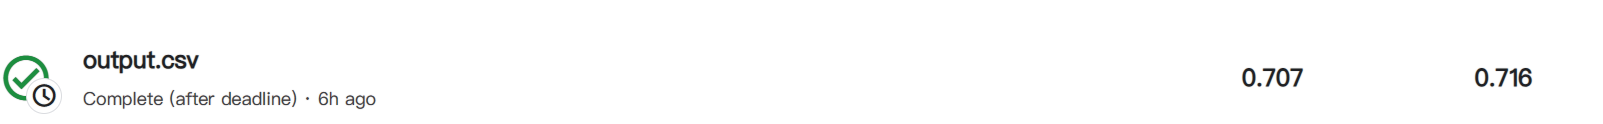